# PRUEBA DE CARGO PARA LÍDER DE LÍNEA DE CONOCIMIENTO EN IA

### Ingeniería de características sobre las variables preprocesadas en las instancias anteriores

En esta etapa se generarán las variables que serán utilizadas para el entrenamiento de los tres modelos solicitados en la prueba, cuyo objetivo es predecir la variable "Annual Turnover".

In [93]:
# import modules for the current script
import pandas as pd
import os
import json
import numpy as np
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [94]:
#############################################
###### Parameters for the execution #########
#############################################

# Get the absolute path to the directory where the script is located
script_dir = os.getcwd()
script_dir = script_dir.replace('\\','/')

anal_data_path = f"{script_dir}/../data/analitycs/preprocessed_dataset/restaurants_dataset.parquet"
type_vars_path = f"{script_dir}/../data/analitycs/preprocessed_dataset/type_vars.json"

In [95]:
# Load the data and type variables
analy_data = pd.read_parquet(anal_data_path)
with open(type_vars_path, 'r') as file: 
    type_vars = json.load(file)

cat_vars = type_vars.get('categorical',[])
num_vars = type_vars.get('numerical',[])
binary_vars = type_vars.get('binary',[])
id_vars = type_vars.get('id_vars',[])
date_var = type_vars.get('date',[])
target_var = "Annual Turnover"

# the backup variable is used given the fact that the target variable was treated to remove outliers
# and we want to keep the original target variable for reference and test the model
test_target_var = "Annual Turnover backup"

In [96]:
# rename the columns to avoid spaces and uppercase letters
analy_data.columns = [col.replace(' ', '_').lower() for col in analy_data.columns]

# remove the spaces and uppercase letters from all the variables types
cat_vars = [var.replace(' ', '_').lower() for var in cat_vars]
num_vars = [var.replace(' ', '_').lower() for var in num_vars]
binary_vars = [var.replace(' ', '_').lower() for var in binary_vars]
id_vars = [var.replace(' ', '_').lower() for var in id_vars]
date_var = [var.replace(' ', '_').lower() for var in date_var]
target_var = target_var.replace(' ', '_').lower()
test_target_var = test_target_var.replace(' ', '_').lower()

In [97]:
# first, we will replace the null values depending on the type of variable
input_threshold = 0.25

# even though we saw in the preprocessing that there are no null values in the target variable, we correct in case it is needed
# given the target value cannot be empty we would drop the rows with null values in the target variable
analy_data = analy_data.dropna(subset=[target_var])
analy_data = analy_data.dropna(subset=[test_target_var])
analy_data = analy_data.dropna(subset=id_vars)

for col in cat_vars:
    if int(analy_data[col].isnull().sum()) > 0:
        if analy_data[col].isnull().sum() / len(analy_data) < input_threshold:
            analy_data[col].fillna(analy_data[col][~(analy_data[col].isna())].mode()[0], inplace=True)
        else:
            analy_data[f"has_{col}"] = [0 if i else 1 for i in analy_data[col].isna()]
            analy_data.drop(columns=[col], inplace=True)
            cat_vars.remove(col)
            binary_vars.append(f"has_{col}")


for col in binary_vars:
    analy_data[col] = analy_data[col].fillna(0)

for col in num_vars + date_var:
    if int(analy_data[col].isnull().sum()) > 0:
        if analy_data[col].isnull().sum() / len(analy_data) < input_threshold:
            if analy_data[col].dtype == 'Int64':
                analy_data[col].fillna(analy_data[col][~(analy_data[col].isna())].mode()[0], inplace=True)
            else:
                analy_data[col].fillna(analy_data[col][~(analy_data[col].isna())].mean(), inplace=True)
        else:
            analy_data[f"has_{col}"] = [0 if i else 1 for i in analy_data[col].isna()]
            analy_data.drop(columns=[col], inplace=True)
            num_vars.remove(col)
            binary_vars.append(f"has_{col}")

# remove the target variable from the numerical variables
num_vars.remove(target_var)
num_vars.remove(test_target_var)

## check if there are still null values in the dataset
analy_data.isnull().sum().sort_values(ascending=False)

registration_number              0
cuisine                          0
city                             0
endorsed_by                      0
restaurant_type                  0
restaurant_location              0
restaurant_theme_mod             0
overall_restaurant_rating        0
food_rating                      0
restaurant_zomato_rating         0
value_for_money                  0
live_music_rating                0
staff_responsivness              0
hygiene_rating                   0
order_wait_time                  0
privacy                          0
ambience                         0
lively                           0
service                          0
comfortablility                  0
annual_turnover                  0
instagram_popularity_quotient    0
facebook_popularity_quotient     0
days_since_open                  0
liquor_license_obtained          0
situated_in_a_multi_complex      0
open_sitting_available           0
resturant_tier                   0
fire_audit          

Con el procesamiento anterior se eliminan o imputan todos los valores nulos de la tabla, lo que permite que los modelos tengan un mejor desempeño. Aunque algunos modelos pueden manejar valores nulos durante el entrenamiento, es necesario tratarlos para aplicar técnicas como PCA.

Tras este procesamiento, se puede proceder con la ingeniería de características para crear variables que aporten valor a la predicción de la variable objetivo.

In [98]:
# list of correlation with the target variable for numerical variables
corr_target = analy_data[num_vars + [target_var]].corr()[target_var].sort_values(ascending=False).reset_index()
corr_target

,index,annual_turnover
0,annual_turnover,1.000000
1,hygiene_rating,0.312679
2,facebook_popularity_quotient,0.237419
3,instagram_popularity_quotient,0.231579
4,live_music_rating,0.220556
5,value_for_money,0.216392
6,staff_responsivness,0.209486
7,restaurant_zomato_rating,0.183914
8,overall_restaurant_rating,0.151079
9,lively,0.066535


Es relevante observar que tanto el ambiente como la comodidad presentan una correlación negativa con el "Annual Turnover".

In [99]:
# list of numerical variables with correlation above |0.15|
correlated_num_vars  = corr_target[abs(corr_target[target_var]) > 0.15]['index'].tolist()
correlated_num_vars.remove(target_var)

In [100]:
# correlation of binary variables with the target variable
corr_binary_target = analy_data[binary_vars + [target_var]].corr()[target_var].sort_values(ascending=False).reset_index()
corr_binary_target

,index,annual_turnover
0,annual_turnover,1.000000
1,fire_audit,0.042826
2,dedicated_parking,0.030872
3,liquor_license_obtained,0.029702
4,restaurant_city_tier,0.026734
5,has_live_sports,0.019614
6,has_comedy_gigs_rating,-0.008030
7,open_sitting_available,-0.008122
8,situated_in_a_multi_complex,-0.037688
9,has_value_deals_rating,-0.140053


In [101]:
analy_data[cat_vars].describe()

,cuisine,city,endorsed_by,restaurant_type,restaurant_location,restaurant_theme_mod
count,3492,3492,3492,3492,3492,3492
unique,20,194,2,3,2,7
top,"tibetan,greek",bangalore,not specific,bar,near party hub,arabian
freq,685,585,1960,3235,2657,1373


In [102]:
## Interaction of the numerical variables that in the EDA showed to have a correlation with the target variable
## and also that with the variables that after the preprocessing were created and have a correlation with the target variable

# mean popularity in social media
analy_data['mean_popularity'] = analy_data[['instagram_popularity_quotient', 'facebook_popularity_quotient']].mean(axis=1)

# square of instagram and facebook popularity
analy_data['instagram_popularity_quotient_squared'] = analy_data['instagram_popularity_quotient'] ** 2
analy_data['facebook_popularity_quotient_squared'] = analy_data['facebook_popularity_quotient'] ** 2

# ratio of instagram to facebook popularity
analy_data['instagram_facebook_popularity_ratio'] = analy_data['instagram_popularity_quotient'] / (analy_data['facebook_popularity_quotient'] + analy_data['facebook_popularity_quotient'].min())  # Adding a small value to avoid division by zero

# interaction of hygiene_rating with instagram and facebook popularity
analy_data['hygiene_rating_instagram_popularity'] = analy_data['hygiene_rating'] * analy_data['instagram_popularity_quotient']
analy_data['hygiene_rating_facebook_popularity'] = analy_data['hygiene_rating'] * analy_data['facebook_popularity_quotient']

# amount of variables with rating superior to certain threshold
cols_rating = [i for i in analy_data.columns if 'rating' in i and 'has' not in i]
analy_data['amount_rating'] = analy_data[cols_rating].apply(lambda x: (x > 5).sum(), axis=1)
analy_data['mean_ratings'] = analy_data[cols_rating].mean(axis=1)

# rating variables interaction with mean popularity
for col in cols_rating:
    analy_data[f'{col}_mean_popularity'] = analy_data[col] * analy_data['mean_popularity']
    num_vars += [f'{col}_mean_popularity']

# restaurant endorsed by a celebrity and high popularity
analy_data['celebrity_endorsed_high_popul'] = [1 if i else 0 for i in ((analy_data['mean_popularity']>=analy_data['mean_popularity'].mean()) & (analy_data['endorsed_by'] == 'celebrity'))]

# append the variables created to the list of numerical variables
num_vars += ['amount_rating','celebrity_endorsed_high_popul','mean_ratings','mean_popularity', 'instagram_popularity_quotient_squared', 'facebook_popularity_quotient_squared', 'instagram_facebook_popularity_ratio','hygiene_rating_instagram_popularity','hygiene_rating_facebook_popularity']

## interaction of the binary variables that in the EDA showed to have a correlation with the target variable
## also, interaction with the created variable has_value_deals_rating given that it has the second highest correlation with the target variable

# liquor license obtained interaction with correlated numerical variables
for col in correlated_num_vars:
    analy_data[f'license_{col}'] = analy_data['liquor_license_obtained'] * analy_data[col]
    num_vars += [f'license_{col}']

# resturant_tier interaction with numerical variables
for col in correlated_num_vars:
    analy_data[f'tier_{col}'] = analy_data['resturant_tier'] * analy_data[col]
    num_vars += [f'tier_{col}']

# has_value_deals_rating interaction with numerical variables
for col in correlated_num_vars:
    analy_data[f'has_value_deals_rating_{col}'] = analy_data['has_value_deals_rating'] * analy_data[col]
    num_vars += [f'has_value_deals_rating_{col}']

In [103]:
# we will remove the city variable from the categorical variables as it has too many unique values
cat_vars.remove('city')

# convert categorical variables to dummy variables
analy_data = pd.get_dummies(analy_data, columns=cat_vars, drop_first=True)

# get the dummy variables created in a list to add to binary
dummy_columns = [col for col in analy_data.columns if any(cat in col for cat in cat_vars)]
binary_vars += dummy_columns
print(dummy_columns)

['cuisine_algerian,belgian', 'cuisine_algerian,korean', 'cuisine_british,belgian', 'cuisine_british,japanese', 'cuisine_chinese,salvadorian', 'cuisine_cuban,british', 'cuisine_hawaiian,latvian', 'cuisine_indian,irish', 'cuisine_irish,belgian', 'cuisine_japanese,thai', 'cuisine_nigerian,cajun', 'cuisine_peruvian,cuban', 'cuisine_polish,jewish', 'cuisine_swedish,greek', 'cuisine_tibetan,greek', 'cuisine_tibetan,italian', 'cuisine_turkish,nigerian', 'cuisine_turkish,sapnish', 'cuisine_welsh,thai', 'endorsed_by_not specific', 'restaurant_type_caffee', 'restaurant_type_gastro bar', 'restaurant_location_near party hub', 'restaurant_theme_mod_arabian', 'restaurant_theme_mod_chinese', 'restaurant_theme_mod_greek', 'restaurant_theme_mod_nature', 'restaurant_theme_mod_others', 'restaurant_theme_mod_parsi']


In [104]:
# highest cuisine effect on the target variable
highest_cuisins = ['tibetan,greek','japanese,thai','irish,belgian']

# cols to interact with the highest cuisines effect on the target variable
# cols are selected based on their correlation with the target variable and EDA analysis, same as the  the highest cuisines
cols_interact = correlated_num_vars + ['has_value_deals_rating','liquor_license_obtained','mean_popularity']

# variable interactions with the highest cuisines effect on the target variable
for col in highest_cuisins:
    for col_interact in cols_interact:
        analy_data[f'{col_interact}_cuisin_{col}'] = analy_data[col_interact] * analy_data[f'cuisine_{col}']
        num_vars += [f'{col_interact}_cuisin_{col}']

# restaurant near party hub and high popularity
analy_data['party_hub_high_popul'] = [1 if i else 0 for i in ((analy_data['mean_popularity']>=analy_data['mean_popularity'].mean()) & (analy_data['restaurant_location_near party hub'] == 1))]
binary_vars += ['party_hub_high_popul']

In [105]:
X_vars = num_vars + binary_vars + date_var
if target_var in X_vars:
    X_vars.remove(target_var)

Y_var = target_var
Y_var_test = test_target_var
print(f"Total number of variables to use in the dataset: {len(X_vars)}")

Total number of variables to use in the dataset: 129


Todas las variables creadas anteriormente fueron diseñadas considerando tanto el análisis exploratorio de datos (EDA) como la correlación entre las distintas variables y la variable objetivo.

En total, la base de datos contiene 129 variables que se emplearán para estimar el "Annual Turnover". Sin embargo, no se utilizarán todas, sino que se realizará una selección de características.

Adicionalmente, dado que la mayoría de las variables son discretas o están definidas en el rango [0,10], y muchas ya presentan una distribución similar a la normal (como se evidenció en el EDA), no es necesario aplicar un StandardScaler para normalizarlas.

Para un análisis preliminar sobre qué variables conviene utilizar, se emplearán dos métodos: primero, un modelo base de XGBoost para estimar la importancia de las variables en la explicación de la variable objetivo; segundo, PCA para obtener los componentes principales que mejor explican la varianza del conjunto de variables explicativas. Posteriormente, se compararán ambos métodos utilizando uno de los tres modelos seleccionados.


## Modelos de ML para predecir la variable Annual Turnover

En esta sección se entrenarán los modelos y se realizarán las pruebas necesarias para identificar la mejor aproximación al reto de predecir la variable objetivo.

En este caso se utilizarán los siguientes modelos para las pruebas:

- **XGBoost**: Se utiliza dado que es un modelo de boosting bastante poderoso para capturar relaciones no lineales entre las variables. Por cómo funciona, es muy importante validar que no se incurra en sobreajuste al momento de entrenar el modelo.
- **Support Vector Regressor**: Es una extensión para regresión del modelo "Support Vector Machine", el cual también permite modelar relaciones no lineales y controlar el sobreajuste.
- **K Nearest Neighbors**: Modelo base para comparar los resultados contra los otros dos modelos que cuentan con una complejidad mayor.

Se descarta el uso de modelos de redes neuronales, ya que aunque estos pueden capturar relaciones complejas entre los datos, dado que la muestra de entrenamiento no tiene el tamaño suficiente, podrían generar overfitting.

También se descarta el uso de modelos paramétricos como regresiones lineales, ya que, tal como se vio en el EDA, las variables explicativas no parecen tener una correlación lineal clara con el "Annual Turnover".

In [140]:
# import modules for the model training
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

### Enfoques para la selección de variables


#### Selección de variables con XGBoost

In [107]:
# X_vars: list of feature columns, Y_var: target variable
X = analy_data[X_vars]
y = analy_data[Y_var]
y_og = analy_data[Y_var_test]
id_var = analy_data[id_vars[0]]

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_og = y_og.loc[y_test.index]

<Figure size 1900x2000 with 0 Axes>

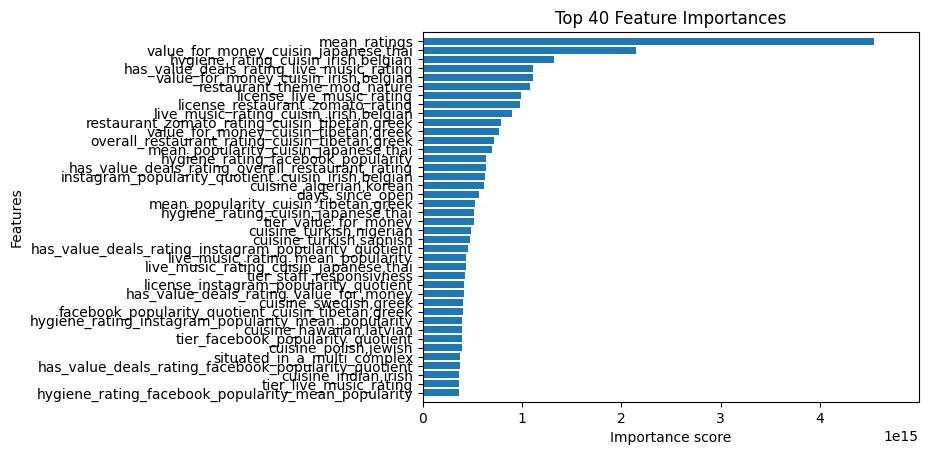

In [108]:
# let's train a XGBoost model to get the feature importance
model = xgb.XGBRegressor(random_state=42,importance_type='gain')
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
features = X_train.columns

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({'feature': features, 'importance': importances})
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(19, 20))
xgb.plot_importance(model,importance_type='gain', max_num_features=40, height=0.8,grid=False,show_values=False)
plt.title('Top 40 Feature Importances')
plt.show()

En este caso, dado que las variables posteriores a "cuisine_polish_jewish" aportan prácticamente la misma cantidad de explicabilidad al modelo, se seleccionarán aquellas cuyo "Importance score" sea superior al de dicha variable. Aunque muchos modelos pueden manejar el sobreajuste causado por un exceso de variables, es una mejor práctica trabajar con un conjunto acotado de variables explicativas, siguiendo el principio de parsimonia.

In [109]:
## variables seleccionadas por el modelo XGBoost
XGBoost_variables_to_use = importances_df[importances_df['importance'] > importances_df[importances_df['feature'] == 'cuisine_polish,jewish']['importance'].values[0]]['feature'].tolist()
print(f"Number of variables to use given by the XGBoost model: {len(XGBoost_variables_to_use)}")

Number of variables to use given by the XGBoost model: 34


In [110]:
# get the train and test sets with the selected variables
X_train_selected = X_train[XGBoost_variables_to_use]
X_test_selected = X_test[XGBoost_variables_to_use]

#### Muestra de entrenamiento creada con PCA

PCA es una técnica de aprendizaje no supervisado comúnmente utilizada para la reducción de dimensionalidad, procurando minimizar la pérdida de información relevante de las variables empleadas en el entrenamiento.

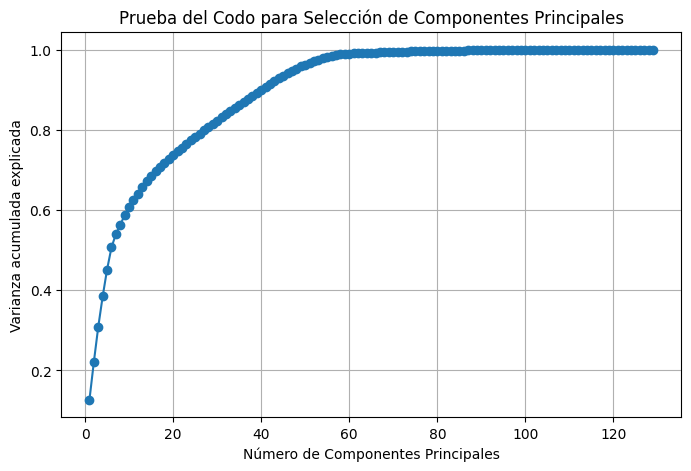

In [111]:
# PCA elbow test for Number of components selection
# Standardize the features before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit PCA
pca = PCA()
pca.fit(X_train_scaled)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Elbow plot (prueba del codo)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza acumulada explicada')
plt.title('Prueba del Codo para Selección de Componentes Principales')
plt.grid(True)
plt.show()

Dada la prueba del codo, se sugiere utilizar aproximadamente 50 componentes principales. Con esta cantidad se reduce a menos de la mitad el número de columnas, manteniendo casi la misma cantidad de varianza explicada que con la tabla completa.

In [112]:
# Transform data using selected number of components
n_components = 50  # Based on the elbow test
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### Entrenamiento de modelos

#### Entrenamiento del modelo XGBoost con ajuste de hiperparámetros

**Modelo XGBoost con hiperparámetros ajustados y variables seleccionadas mediante feature importance**

In [ ]:
# Define base model
xgb_model = xgb.XGBRegressor(random_state=42)

# grid search used to find the best hyperparameters for the XGBoost model
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5, 7],
#      'learning_rate': [0.01, 0.1, 0.2],
#      'subsample': [0.8, 1],
#     'colsample_bytree': [0.8, 1]
# }

# define hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [200],
    'max_depth': [5],
     'learning_rate': [0.01],
     'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# configure the GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', # we use negative MSE as scoring to maximize the score as GridSearchCV tries to maximize the metric
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# train the model with hyperparameter tuning
grid_search.fit(X_train_selected, y_train)

# best model and hyperparameters
print("Best parameters found:", grid_search.best_params_)
print("Best CV score (neg MSE):", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV score (neg MSE): -185781424256343.16


Vale la pena destacar que, para obtener resultados más robustos, sería recomendable probar una mayor cantidad de combinaciones de hiperparámetros, con el fin de asegurar la selección del mejor conjunto posible.

In [ ]:
# use the best model to predict on the test set and compare with the original target variable
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)

# get the rmse and mae from the prediction
print("RMSE:", np.sqrt(np.mean((y_test_og - y_pred) ** 2)))
print("MAE:", np.mean(np.abs(y_test_og - y_pred)))
r2 = r2_score(y_test_og, y_pred)
print("R²:", r2)

# get the rmse and mae from the prediction in therms of standard deviation
std_target = analy_data[Y_var].std()
print("RMSE/std:", np.sqrt(np.mean((y_test_og - y_pred) ** 2))/std_target)
print("MAE/std:", np.mean(np.abs(y_test_og - y_pred))/std_target)

RMSE: 14820135.583346877
MAE: 9894824.51788269
R²: 0.2084355354309082
RMSE/std: 0.9611245717951388
MAE/std: 0.6417052613489203


Text(0, 0.5, 'Frecuencia')

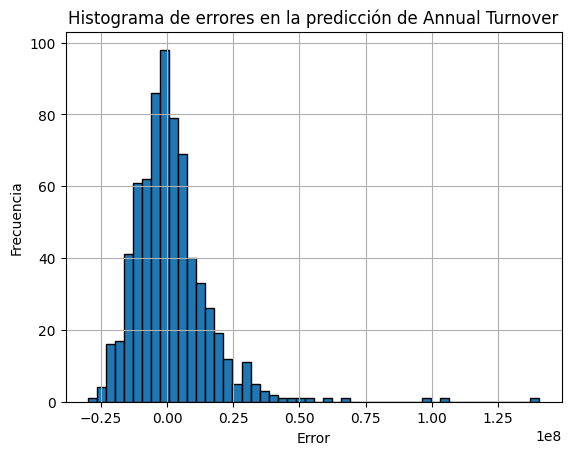

In [ ]:
# histogram of the errors
(y_test_og - y_pred).hist(bins=50, edgecolor='black')
plt.title('Histograma de errores en la predicción de Annual Turnover')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

En la gráfica anterior se observa que el error está centrado en cero; sin embargo, presenta una cola más larga hacia los errores en los que la predicción subestima el valor real. Esto se debe, como se explicó previamente, a la presencia de valores atípicos en la variable objetivo.

Se observa que el MAE es considerablemente menor que el RMSE, ya que en este caso los resultados se comparan contra la variable objetivo sin controlar los outliers. Es decir, los outliers de la variable objetivo se controlaron durante el entrenamiento para evitar sesgos en el modelo, pero la comparación se realiza contra la variable original.

**Modelo XGBoost con hiperparámetros ajustados y PCA**

In [ ]:
# Define base model
xgb_model_pca = xgb.XGBRegressor(random_state=42)

# define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [200],
    'max_depth': [7],
    'learning_rate': [0.01],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# configure the GridSearchCV
grid_search_pca = GridSearchCV(
    estimator=xgb_model_pca,
    param_grid=param_grid, # same hyperparameters as before for comparisson
    scoring='neg_mean_squared_error', # we use negative MSE as scoring to maximize the score as GridSearchCV tries to maximize the metric
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# train the model with hyperparameter tuning
grid_search_pca.fit(X_train_pca, y_train)

# best model and hyperparameters
print("Best parameters found:", grid_search_pca.best_params_)
print("Best CV score (neg MSE):", grid_search_pca.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV score (neg MSE): -191222507691696.22


In [145]:
# use the best model to predict on the test set and compare with the original target variable
best_model_pca = grid_search_pca.best_estimator_
y_pred_xgboost_pca = best_model_pca.predict(X_test_pca)

# get the rmse and mae from the prediction
print("RMSE:", np.sqrt(np.mean((y_test_og - y_pred_xgboost_pca) ** 2)))
print("MAE:", np.mean(np.abs(y_test_og - y_pred_xgboost_pca)))
print("R²:", r2_score(y_test_og, y_pred_xgboost_pca))

# get the rmse and mae from the prediction in therms of standard deviation
std_target = analy_data[Y_var].std()
print("RMSE/std:", np.sqrt(np.mean((y_test_og - y_pred_xgboost_pca) ** 2))/std_target)
print("MAE/std:", np.mean(np.abs(y_test_og - y_pred_xgboost_pca))/std_target)

RMSE: 14989839.764691833
MAE: 9912772.206008583
R²: 0.1902034878730774
RMSE/std: 0.9721303320130342
MAE/std: 0.6428692158868325


Text(0, 0.5, 'Frecuencia')

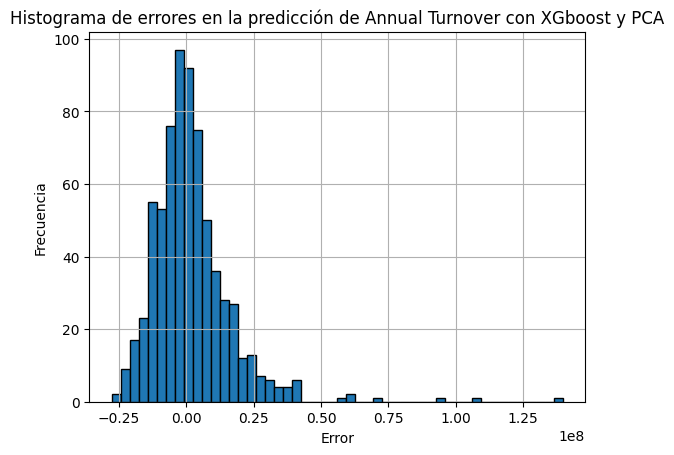

In [ ]:
# histogram of the errors
(y_test_og - y_pred_xgboost_pca).hist(bins=50, edgecolor='black')
plt.title('Histograma de errores en la predicción de Annual Turnover con XGboost y PCA')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

En este caso, el modelo XGBoost con PCA muestra un rendimiento ligeramente inferior al obtenido mediante la selección de características basada en la importancia de variables del propio modelo XGBoost. Es importante resaltar que estas pruebas no son concluyentes respecto a la mejor estrategia de reducción de dimensionalidad, ya que no se exploró una grilla de hiperparámetros lo suficientemente amplia.

Por otro lado, dado este resultado, para los otros dos modelos se utilizará el conjunto de entrenamiento que mostró el mejor desempeño, lo que además reduce el número de columnas y, por ende, el tiempo de entrenamiento. Sin embargo, esto no implica que PCA sea inferior a la aproximación basada en XGBoost en todos los casos; simplemente, para simplificar las pruebas, se opta por esta estrategia.

#### Entrenamiento del modelo KNN con ajuste de hiperparámetros

In [ ]:
# Define the KNN model
knn = KNeighborsRegressor()

# grid used to find the best hyperparameters for the KNN model
# param_grid_knn = {
#     'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 40, 80],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]  # 1: Manhattan, 2: Euclidiana
# }

# define the hyperparameters grid for KNN
param_grid_knn = {
    'n_neighbors': [80],
    'weights': ['distance'],
    'p': [1]  # 1: Manhattan, 2: Euclidiana
}

# define de cross-validation strategy
cv_knn = KFold(n_splits=5, shuffle=True, random_state=42)

# configure GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring='neg_mean_squared_error',
    cv=cv_knn,
    verbose=2,
    n_jobs=-1
)

# train the model with the selected variables X_train_selected
grid_search_knn.fit(X_train_selected, y_train)

# Result
print("Mejores hiperparámetros encontrados:", grid_search_knn.best_params_)
print("Mejor score de validación cruzada (neg MSE):", grid_search_knn.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros encontrados: {'n_neighbors': 80, 'p': 1, 'weights': 'distance'}
Mejor score de validación cruzada (neg MSE): -201879005067717.4


In [144]:
# Predicción en el set de prueba
y_pred_knn = grid_search_knn.best_estimator_.predict(X_test_selected)

# Evaluación
print("RMSE:", np.sqrt(mean_squared_error(y_test_og, y_pred_knn)))
print("MAE:", mean_absolute_error(y_test_og, y_pred_knn))
print("R²:", r2_score(y_test_og, y_pred_knn))

# Evaluación
print("RMSE/std:", np.sqrt(mean_squared_error(y_test_og, y_pred_knn))/std_target)
print("MAE/std:", mean_absolute_error(y_test_og, y_pred_knn)/std_target)

RMSE: 15407072.153731434
MAE: 10468749.876990123
R²: 0.1444957856110558
RMSE/std: 0.9991889441964045
MAE/std: 0.6789258226529843


#### Entrenamiento del modelo SVR con ajuste de hiperparámetros

In [ ]:
# Definir el modelo base
svr = SVR()

# param grid used to find the best hyperparameters for the SVR model
# param_grid_svr = {
#     'kernel': ['rbf', 'linear'],
#     'C': [0.1, 1, 10, 100],
#     'epsilon': [0.01, 0.1, 0.5, 1],
#     'gamma': ['scale', 'auto']
# }


# Definir la grilla de hiperparámetros
param_grid_svr = {
    'kernel': ['linear'],
    'C': [100],
    'epsilon': [0.01],
    'gamma': ['scale']
}

# Definir la estrategia de validación cruzada
cv_svr = KFold(n_splits=5, shuffle=True, random_state=42)

# Configurar GridSearchCV
grid_search_svr = GridSearchCV(
    estimator=svr,
    param_grid=param_grid_svr,
    scoring='neg_mean_squared_error',
    cv=cv_svr,
    verbose=2,
    n_jobs=-1
)

# Entrenar el modelo (puedes usar X_train_selected o X_train_pca)
grid_search_svr.fit(X_train_selected, y_train)

# Resultados
print("Mejores hiperparámetros encontrados:", grid_search_svr.best_params_)
print("Mejor score de validación cruzada (neg MSE):", grid_search_svr.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Mejores hiperparámetros encontrados: {'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Mejor score de validación cruzada (neg MSE): -193991827283175.75


In [143]:
# Predicción en el set de prueba
y_pred_svr = grid_search_svr.best_estimator_.predict(X_test_selected)

# Evaluación
print("RMSE:", np.sqrt(mean_squared_error(y_test_og, y_pred_svr)))
print("MAE:", mean_absolute_error(y_test_og, y_pred_svr))
print("R²:", r2_score(y_test_og, y_pred_svr))
print("RMSE/std:", np.sqrt(mean_squared_error(y_test_og, y_pred_svr))/std_target)
print("MAE/std:", mean_absolute_error(y_test_og, y_pred_svr)/std_target)

RMSE: 15097764.57927248
MAE: 9926871.722780157
R²: 0.1785006604485121
RMSE/std: 0.9791295386408367
MAE/std: 0.6437836064430718


### Ajuste de hiperparametros adicional para el mejor modelo

Dado que se selecciono el mejor modelo base con una grilla de hiperparametros limitada, se van a enfocar ahora los recursos en seleccionar una grilla de hiperparametros mejor personalizada para el modelo con el mejor performace y asi, intentar obtener un mejor resultado

In [ ]:
# Doing further tunning for the best model
xgb_model = xgb.XGBRegressor(random_state=42,tree_method="gpu_hist")

# grid search used to find the best hyperparameters for the XGBoost model
# param_grid_best = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [5, 6, 7],
#     'learning_rate': [0.05, 0.01, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1],
#     'colsample_bytree': [0.5, 0.8, 1]
# }

# define hyperparameters for GridSearchCV
param_grid_best = {
    'n_estimators': [500],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01],
    'subsample': [0.6],
    'colsample_bytree': [0.5]
}

# define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# configure the GridSearchCV
grid_search_best = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_best,
    scoring='neg_mean_squared_error', # we use negative MSE as scoring to maximize the score as GridSearchCV tries to maximize the metric
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# train the model with hyperparameter tuning
grid_search_best.fit(X_train_selected, y_train)

# best model and hyperparameters
print("Best parameters found:", grid_search_best.best_params_)
print("Best CV score (neg MSE):", grid_search_best.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}
Best CV score (neg MSE): -182672852367673.06


NameError: name 'grid_search_best' is not defined

In [ ]:
# Predicción en el set de prueba
y_pred_best = grid_search_best.best_estimator_.predict(X_test_selected)

# Evaluación
print("RMSE:", np.sqrt(mean_squared_error(y_test_og, y_pred_best)))
print("MAE:", mean_absolute_error(y_test_og, y_pred_best))
print("R²:", r2_score(y_test_og, y_pred_best))
print("RMSE/std:", np.sqrt(mean_squared_error(y_test_og, y_pred_best))/std_target)  
print("MAE/std:", mean_absolute_error(y_test_og, y_pred_best)/std_target)